# Séries de tempo

( https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html )


Time Series é considerado uma das habilidades menos conhecidas no espaço de análise (Mesmo eu tinha pouca pista sobre isso alguns dias atrás). Mas como você sabe que o nosso primeiro Hackathon Mini é baseado nele, eu me preparo para uma jornada para aprender os passos básicos para resolver um problema de Séries Temporais e aqui estou compartilhando o mesmo com você. Estes definitivamente ajudarão você a obter um modelo decente em nosso hackathon hoje.


    1 - O que torna a série de tempo especial?
    2 - Carregando e manuseando séries temporais em pandas
    3 - Como verificar o estacionarismo de uma série temporal?
    4 - Como fazer uma série temporal estacionária?
    5 - Previsão de uma série temporal
    
    
### 1. O que torna a série temporal especial?
Como o nome sugere, TS é uma coleção de pontos de dados coletados em intervalos de tempo constantes . Estes são analisados para determinar a tendência de longo prazo, de modo a prever o futuro ou realizar alguma outra forma de análise. Mas o que faz um TS diferente de dizer um problema de regressão regular? Existem duas coisas:

* É dependente do tempo . Portanto, a suposição básica de um modelo de regressão linear que as observações são independentes não vale neste caso. 
* Juntamente com uma tendência crescente ou decrescente, a maioria dos TS tem alguma forma de tendências de sazonalidade , ou seja, variações específicas de um determinado período de tempo. Por exemplo, se você ver as vendas de uma jaqueta de lã ao longo do tempo, você invariavelmente encontrará maiores vendas nas temporadas de inverno.


Por causa das propriedades inerentes de um TS, existem várias etapas envolvidas na análise. Estes são discutidos em detalhes abaixo. Vamos começar carregando um objeto TS no Python. Nós estaremos usando o popular conjunto de dados AirPassengers.

### 2. Carregando e Manipulando Séries Temporais em Pandas

O Pandas possui bibliotecas dedicadas para manipular objetos TS, particularmente a classe datatime64 [ns]  que armazena informações de tempo e nos permite executar algumas operações realmente rápidas. Vamos começar ativando as bibliotecas necessárias:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


plt.rcParams ['figure.figsize'] = 15, 6

data = pd.read_csv('./data/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Os dados contêm um mês e um número específicos de passageiros viajando naquele mês. Mas isso ainda não é lido como um objeto TS, pois os tipos de dados são 'objeto' e 'int'. Para ler os dados como uma série temporal, temos que passar argumentos especiais para o comando read_csv:

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

data = pd.read_csv('./data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Vamos entender os argumentos um por um:

- 1) **parse_dates** : especifica a coluna que contém as informações de data e hora. Como dissemos acima, o nome da coluna é 'Mês'.

- 2) **index_col**: Uma idéia-chave por trás do uso de Pandas para dados TS é que o índice deve ser a variável que descreve as informações de data e hora. Então este argumento diz aos pandas para usarem a coluna 'Mês' como índice.

- 3) **date_parser**: especifica uma função que converte uma string de entrada em uma variável datetime. Por padrão, o Pandas lê dados no formato 'AAAA-MM-DD HH: MM: SS'. Se os dados não estiverem nesse formato, o formato deverá ser definido manualmente. Algo parecido com a função de busca de dados definida aqui pode ser usado para este propósito.

Agora podemos ver que os dados têm objeto de tempo como índice e #Passengers como a coluna. Podemos cruzar o tipo de dados do índice com o seguinte comando:

In [4]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Observe o dtype = 'datetime [ns]', que confirma que é um objeto datetime. Como uma preferência pessoal, eu converteria a coluna em um objeto de série para evitar referir nomes de colunas toda vez que eu usar o TS. Por favor, sinta-se livre para usar como um dataframe é que funciona melhor para você.

### 3. Como verificar a estacionariedade de uma série temporal?

Uma TS é considerada estacionária se suas propriedades estatísticas , como média, variância permanecer constante ao longo do tempo . Mas por que isso é importante? A maioria dos modelos TS trabalha no pressuposto de que o TS é estacionário. Intuitivamente, podemos afirmar que se um TS tem um comportamento particular ao longo do tempo, existe uma probabilidade muito alta de que ele siga o mesmo no futuro. Além disso, as teorias relacionadas a séries estacionárias são mais maduras e mais fáceis de implementar em comparação com séries não estacionárias.

A estacionariedade é definida usando um critério muito estrito. No entanto, para fins práticos, podemos supor que a série seja estacionária se ela tiver propriedades estatísticas constantes ao longo do tempo, isto é. Os seguintes:

- média constante
- variância constante
- uma autocovariância que não depende do tempo.

Vou pular os detalhes, pois é muito claramente definido neste artigo . Vamos para as maneiras de testar a estacionariedade. Primeiro e mais importante é simples traçar os dados e analisar visualmente. Os dados podem ser plotados usando o seguinte comando:

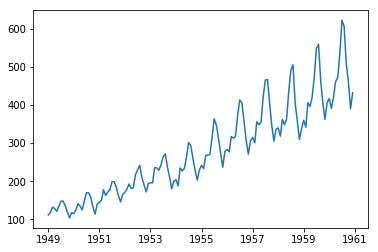

In [5]:
plt.plot(data)

É claramente evidente que há uma tendência geral crescente nos dados, juntamente com algumas variações sazonais. No entanto, nem sempre é possível fazer tais inferências visuais (veremos esses casos mais tarde). Então, mais formalmente, podemos verificar a estacionariedade usando o seguinte:

- **Plotando Rolando Estatísticas**: Podemos traçar a média móvel ou variância móvel e ver se varia com o tempo. Ao mover a média / variância, quero dizer que, em qualquer instante, 't', consideraremos a média / variância do último ano, isto é, os últimos 12 meses. Mas, novamente, isso é mais uma técnica visual.


- **Teste Dickey-Fuller**: Este é um dos testes estatísticos para verificar a estacionariedade. Aqui a hipótese nula é que o TS é não-estacionário. Os resultados do teste compreendem uma estatística de teste e alguns  valores críticos para os níveis de confiança de diferença. Se a estatística de teste for menor que o valor crítico, podemos rejeitar a hipótese nula e dizer que a série é estacionária. Consulte este artigo para detalhes.

Esses conceitos podem não parecer muito intuitivos neste momento. Eu recomendo passar pelo artigo prequel. Se você estiver interessado em alguma estatística teórica, você pode consultar Introdução a Séries Temporais e Previsão  por Brockwell e Davis . O livro é um pouco pesado para as estatísticas, mas se você tiver a habilidade de ler as entrelinhas, poderá entender os conceitos e tangenciar as estatísticas tangencialmente.

De volta à verificação da estacionariedade, usaremos muito os gráficos estatísticos de rolagem juntamente com os resultados do teste Dickey-Fuller, de modo que defini uma função que recebe um TS como entrada e os gerou para nós. Por favor, note que eu tracei desvio padrão ao invés de variância para manter a unidade semelhante à média.

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
#     print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)

O código é bem direto. Por favor, sinta-se à vontade para discutir o código nos comentários se você enfrentar desafios ao compreendê-lo. Vamos executá-lo para nossas séries de entrada:

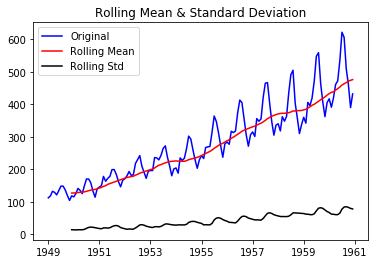

In [12]:
test_stationarity(data)

### 4. Como fazer uma série temporal estacionária?

Embora a suposição de estacionariedade seja tomada em muitos modelos TS, quase nenhuma das séries temporais práticas é estacionária. Então, os estatísticos descobriram maneiras de tornar as séries estacionárias, o que discutiremos agora. Na verdade, é quase impossível fazer uma série perfeitamente estacionária, mas tentamos levá-la o mais perto possível. Vamos entender o que está tornando um TS não estacionário. Existem duas razões principais por trás do não estacionarista de um TS: 

- 1. Tendência - variação média ao longo do tempo. Por exemplo, neste caso, vimos que, em média, o número de passageiros estava crescendo com o tempo. 
- 2. Sazonalidade - variações em intervalos de tempo específicos. Por exemplo, as pessoas podem ter a tendência de comprar carros em um determinado mês devido ao aumento de salário ou festivais.


O princípio subjacente é modelar ou estimar a tendência e a sazonalidade da série e removê-la da série para obter uma série estacionária. Em seguida, as técnicas de previsão estatística podem ser implementadas nesta série. A etapa final seria converter os valores previstos na escala original aplicando as restrições de tendência e sazonalidade. Nota: discutirei vários métodos. Alguns podem funcionar bem neste caso e outros não. Mas a ideia é pegar um jeito de todos os métodos e não focar apenas no problema em questão. Vamos começar trabalhando na parte da tendência. 

### Estimando e eliminando tendências 

Um dos primeiros truques para reduzir a tendência pode ser a transformação. Por exemplo, neste caso, podemos ver claramente que há uma tendência positiva significativa. Assim, podemos aplicar transformações que penalizam valores mais altos do que valores menores. Estes podem ser um log, raiz quadrada, raiz cúbica, etc. Vamos pegar uma transformação log aqui para simplificar:


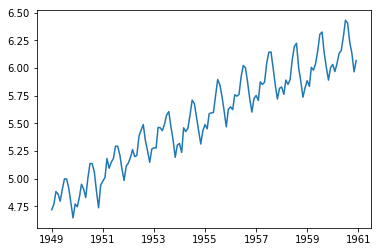

In [13]:
ts_log = np.log(data)
plt.plot(ts_log)

Neste caso mais simples, é fácil ver uma tendência de avanço nos dados. Mas não é muito intuitivo na presença de ruído. Assim, podemos usar algumas técnicas para estimar ou modelar essa tendência e, em seguida, removê-la da série. Pode haver muitas maneiras de fazer isso e algumas das mais usadas são: 

- Agregação - tomando a média por um período de tempo como médias mensais / semanais
- Suavização - tendo médias móveis 
- Ajuste polinomial - ajuste um modelo de regressão 

Suavização refere-se a estimativas contínuas, ou seja, considerando os últimos instantes. Existem várias maneiras, mas vou discutir duas delas aqui. 

### Média móvel

Nesta abordagem, tomamos a média de valores consecutivos de "k" dependendo da frequência das séries temporais. Aqui podemos tirar a média dos últimos 1 ano, ou seja, últimos 12 valores. Os pandas têm funções específicas definidas para determinar as estatísticas de rolagem.

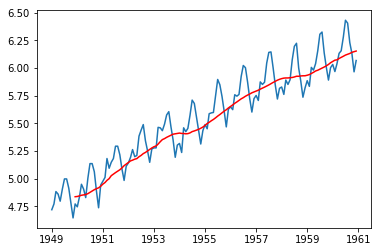

In [14]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

A linha vermelha mostra a média de rolamento. Vamos subtrair isso da série original. Observe que, como estamos tirando a média dos últimos 12 valores, a média de rolagem não está definida para os primeiros 11 valores. Isso pode ser observado como:

In [15]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(16)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


Observe os 11 primeiros sendo Nan. Vamos descartar esses valores NaN e verificar os gráficos para testar a estacionariedade.

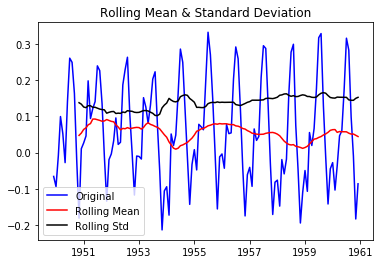

In [16]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Isto parece uma série muito melhor. Os valores de rolagem parecem estar variando um pouco, mas não há uma tendência específica.

No entanto, uma desvantagem nessa abordagem particular é que o período de tempo deve ser estritamente definido. Neste caso, podemos obter médias anuais, mas em situações complexas, como a previsão de um preço de ações, é difícil encontrar um número. Então, pegamos uma "média móvel ponderada", em que valores mais recentes recebem um peso maior. Pode haver muitas técnicas para atribuir pesos.

O próximo tópico seria como **Eliminar tendência e sazonalidade** mas vamos deixa-lo de lado para evitar a parte complicada do tema e quem está confortavel e precisa evoluir no assunto, os dois subtópicos seriam: Diferenciação & Decomposição

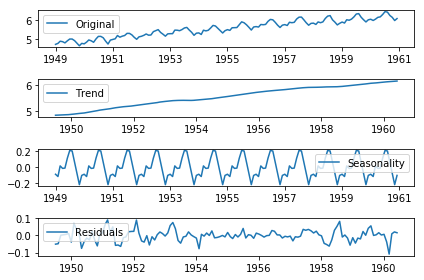

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Forecasting

Familia ARIMA

Deixe-me dar uma breve introdução ao ARIMA . Não vou entrar nos detalhes técnicos, mas você deve entender esses conceitos detalhadamente se quiser aplicá-los com mais eficiência. ARIMA significa Médias Móveis Integradas Auto-Regressivas . A previsão ARIMA para uma série temporal estacionária nada mais é que uma equação linear (como uma regressão linear). Os preditores dependem dos parâmetros (p, d, q) do modelo ARIMA:


Algumas palavras sobre o modelo. Letra por letra, construiremos o nome completo - ARIMA (p, d, q).


- **AR (p)** - modelo de autorregressão, isto é, regressão da série temporal em si. Premissa básica - os valores da série atual dependem de seus valores anteriores com algum atraso (ou várias defasagens). O atraso máximo no modelo é referido como p. Para determinar o p inicial. (em econometria analisamos um grafico chamado PACF para anlisar o p, em machine learning faremos via grid search).

- ** MA (q)** - modelo de média móvel. Sem entrar em detalhes, modela o erro da série temporal, novamente a suposição é - o erro atual depende do anterior com algum atraso, que é referido como q. (em econometria usamos o grafico ACF).

Vamos fazer uma pequena pausa e combinar as primeiras 4 letras:

**AR(p) + MA(q) = ARMA(p,q)**

O que temos aqui é o modelo de médio movimento autorregressivo! Se a série é estacionária, pode ser aproximada com essas 4 letras. Devemos continuar?

- **I(d)**— ordem de integração. É simplesmente o número de diferenças não sazonais necessárias para tornar a série estacionária. Como a ideia de estacionariedade é razoavelmente complicada para essa introdução, vamos defini-la apenas como uma curva "bem comportada", que em séries temporais seria algo não explosivo, com variância constante e sazonalidade constante.

**AR(p) + I(d) + MA(q) = ARIMA(p,d,q)**

Há outros filtros como o S de sazonal e outras formas funcionais como o VAC e o VEC e até modelos que preevem volatidade (muito usado no mercado financeiro) como os GARCH. Aqui ficaremos no mais simples.


Uma preocupação importante aqui é como determinar o valor de 'p' e 'q'. Nós usamos dois gráficos para determinar esses números. Vamos discuti-los primeiro.

**Função de Autocorrelação (ACF)**: É uma medida da correlação entre o TS com uma versão defasada de si mesmo. Por exemplo, no intervalo 5, o ACF compararia as séries no instante de tempo 't1' ... 't2' com as séries no instante 't1-5'… 't2-5' (t1-5 e t2 sendo pontos finais).


**Função de Autocorrelação Parcial (PACF)**: Mede a correlação entre a TS com uma versão defasada de si mesma, mas depois elimina as variações já explicadas pelas comparações intervenientes. Por exemplo, no lag 5, ele verificará a correlação, mas removerá os efeitos já explicados pelos lags 1 a 4.

In [18]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [19]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff = ts_log_diff.dropna()
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

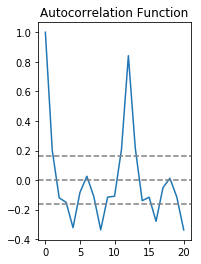

In [20]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

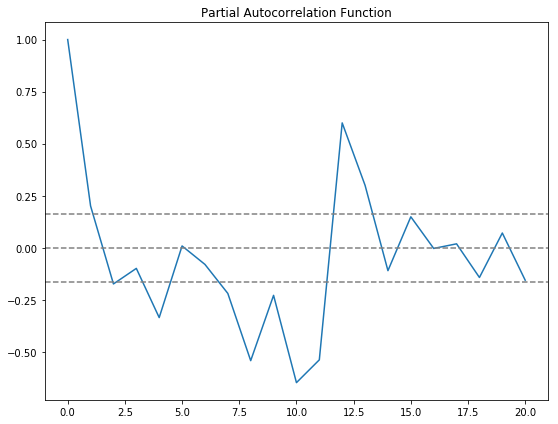

In [49]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Neste gráfico, as duas linhas pontilhadas em ambos os lados de 0 são os intervalos de confiança. Estes podem ser usados para determinar os valores 'p' e 'q' como:

p - O valor de retardo em que o gráfico PACF cruza o intervalo de confiança superior pela primeira vez. Se você notar de perto, neste caso p = 2.

q - O valor de retardo no qual o gráfico ACF cruza o intervalo de confiança superior pela primeira vez. Se você notar de perto, neste caso, q = 2.

Agora, vamos criar 3 modelos ARIMA diferentes, considerando efeitos individuais e combinados. Também vou imprimir o RSS para cada um. Por favor, note que aqui RSS é para os valores dos resíduos e não séries reais.

Precisamos carregar o modelo ARIMA primeiro:

In [26]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


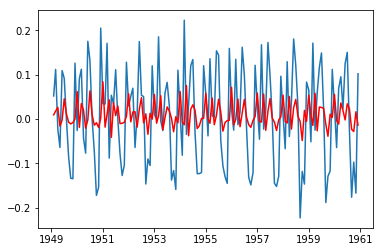

In [27]:
# MODELO AR
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')

C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


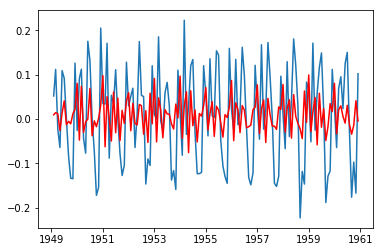

In [28]:
# MODELO MA

model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')

C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


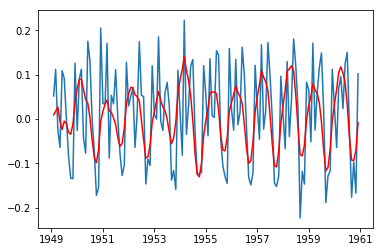

In [32]:
# Combinando AR + MA 

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [33]:
### Sazonalidade
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(ts_log,
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6964      0.251     -2.771      0.006      -1.189      -0.204
ar.L2          0.0865      0.205      0.423      0.673      -0.315       0.488
ma.L1          0.2710      0.221      1.226      0.220      -0.162       0.704
ma.L2         -0.4450      0.167     -2.662      0.008      -0.773      -0.117
ar.S.L12      -0.4651      0.084     -5.523      0.000      -0.630      -0.300
sigma2         0.0014      0.000      8.238      0.000       0.001       0.002


In [66]:
plt.style.use('fivethirtyeight')

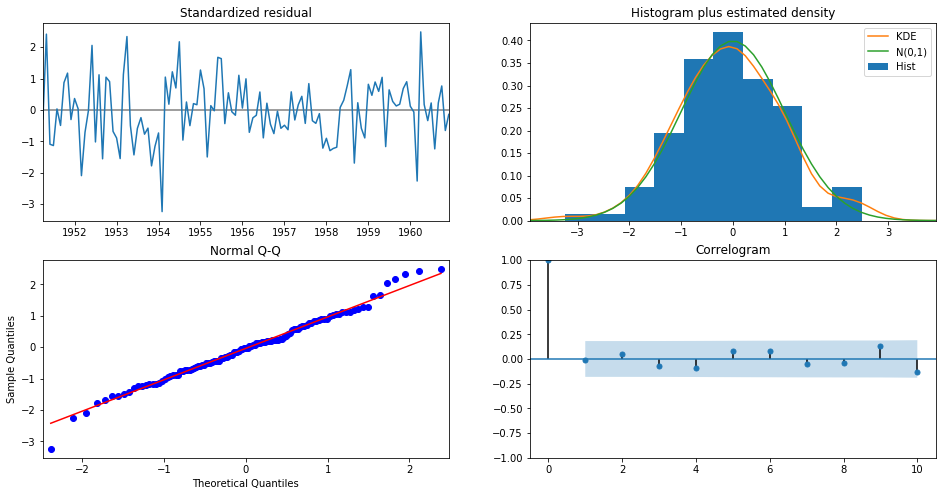

In [34]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Fazendo testes


Exemplo do crossvalidation com timeseries
<img src='./img/crossvalidation.png'>

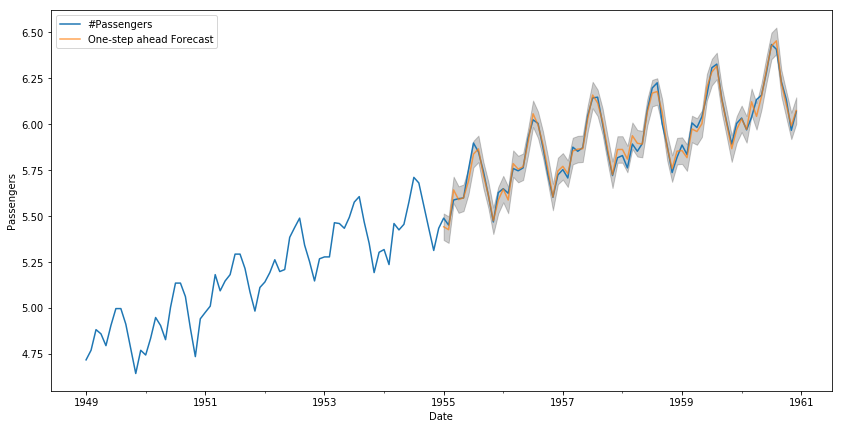

In [36]:
pred = results.get_prediction(start=pd.to_datetime('1955-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts_log['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

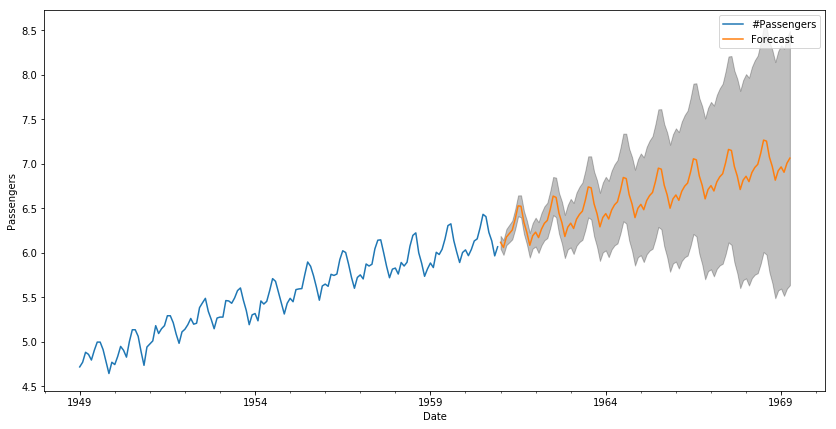

In [37]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ts_log.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

### Parte 2 - A
Usando fbprophet

Série de tempo 

Venda de móveis vs material de escritório 

De acordo com nossos dados, houve um número muito maior de vendas de materiais de escritório do que de móveis ao longo dos anos.

Vamos comparar as vendas de duas categorias no mesmo período de tempo. Isso significa combinar dois quadros de dados em um e plotar as séries temporais dessas duas categorias em um único gráfico.


In [93]:
df = pd.read_excel('./data/Sample - Superstore.xls')

In [94]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [95]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [96]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

C:\Users\sn3fru\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


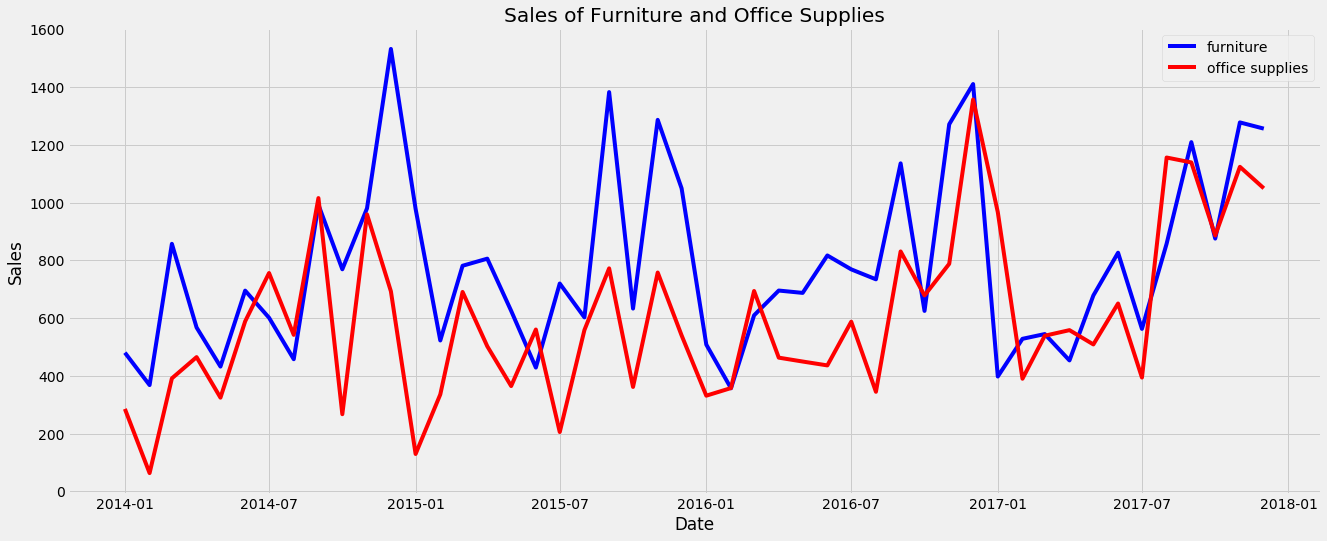

In [97]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

Observamos que as vendas de móveis e materiais de escritório compartilhavam um padrão sazonal similar. Início do ano é a entressafra para ambas as categorias. Parece que o horário de verão também é tranquilo para o material de escritório. Além disso, a média diária de vendas de móveis é maior do que a dos materiais de escritório na maioria dos meses. É compreensível, já que o valor do mobiliário deve ser muito maior do que o valor do material de escritório. Ocasionalmente, o material de escritório passava a mobília em média de vendas diárias. Vamos descobrir quando foi a primeira vez que as vendas de material de escritório ultrapassaram as vendas de móveis.


In [99]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


# Modelando com facebook prophet

Lançada pelo Facebook em 2017, a ferramenta de previsão Profeta foi projetada para analisar séries temporais que exibem padrões em diferentes escalas de tempo, como anual, semanal e diária. Ele também possui recursos avançados para modelar os efeitos de feriados em uma série de tempo e implementar pontos de mudança personalizados. Portanto, estamos usando o Prophet para colocar um modelo em funcionamento.


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

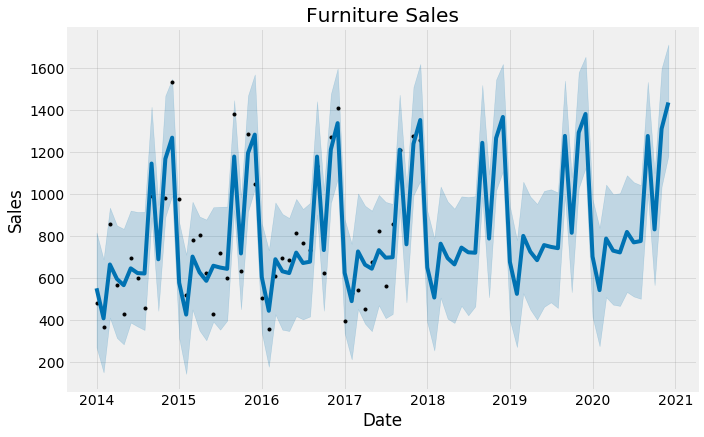

In [100]:
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)


furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

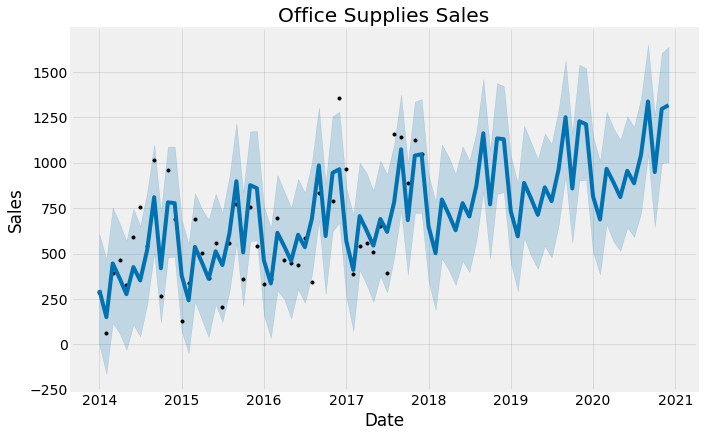

In [101]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

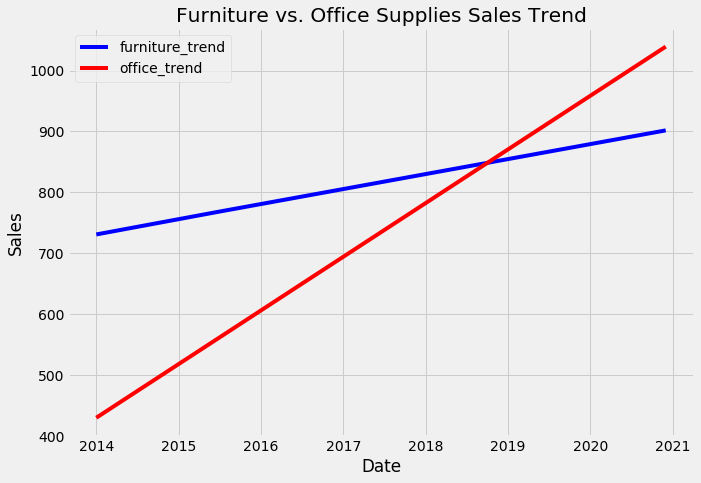

In [103]:
# Comparando as previsões

furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)


plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');


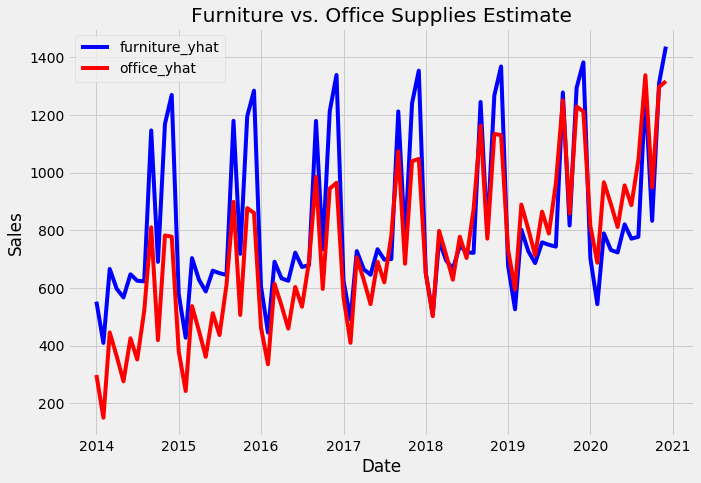

In [104]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

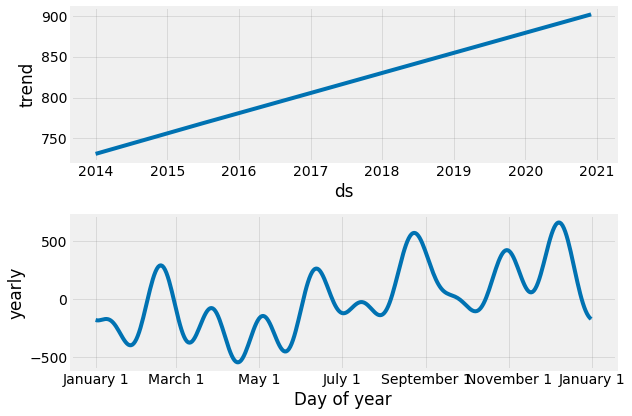

In [105]:
furniture_model.plot_components(furniture_forecast);

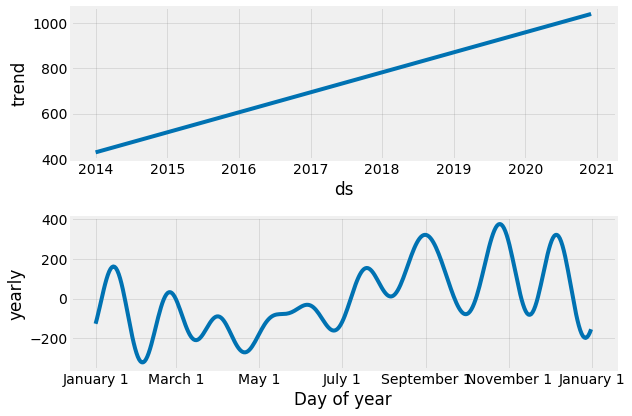

In [106]:
office_model.plot_components(office_forecast);


É bom ver que as vendas de móveis e material de escritório aumentaram linearmente ao longo do tempo e continuarão crescendo, embora o crescimento do material de escritório pareça um pouco mais forte. 

O pior mês para móveis é abril, o pior mês para material de escritório é fevereiro.
O melhor mês para móveis é dezembro, e o melhor mês para material de escritório é outubro. 

Existem muitas análises de séries temporais que podemos explorar a partir de agora, como previsão com limites de incerteza, ponto de mudança e detecção de anomalias, previsão de séries temporais com fonte de dados externa. Nós apenas começamos.


### Parte 2 - B

Usando fbprophet para dados de ações.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

In [40]:
import quandl # quandl for financial data
import pandas as pd

quandl.ApiConfig.api_key = '' #getyourownkey!

# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')

# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


In [41]:
gm.to_csv('gm.csv')
tesla.to_csv('tesla.csv')

Existe uma quantidade quase ilimitada de dados no quandl, mas eu queria me concentrar em comparar duas empresas dentro do mesmo setor, a Tesla e a General Motors. A Tesla é uma empresa fascinante não apenas porque é a primeira empresa americana de sucesso em 111 anos, mas também porque, em 2017, era a empresa de automóveis mais valiosa dos Estados Unidos, apesar de vender apenas quatro carros diferentes. A outra concorrente do título de empresa de automóveis mais valiosa é a General Motors, que recentemente mostrou sinais de abraçar o futuro dos carros construindo alguns veículos totalmente elétricos (mas não com aparência legal).


## Exploração de Dados

Antes de entrarmos na modelagem, é melhor ter uma ideia da estrutura e dos intervalos fazendo alguns gráficos exploratórios. Isso também nos permite procurar outliers ou valores ausentes que precisam ser corrigidos. Se qualquer um dos códigos gráficos parecer intimidador, não se preocupe. Eu também acho que o matplotlib não é intuitivo e, muitas vezes, copia e cola exemplos do Stack Overflow ou da documentação para obter o gráfico que quero. Uma das regras da programação é não reinventar uma solução que já existe!

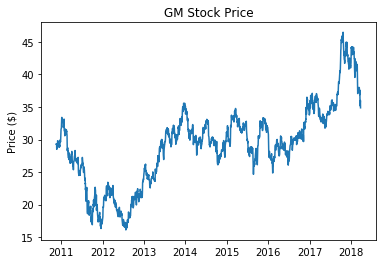

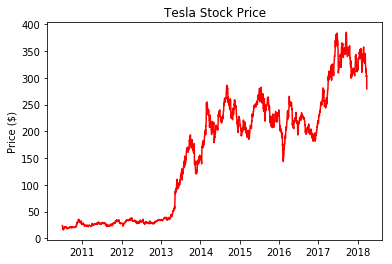

In [42]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

In [51]:
tesla.set_index('Date', inplace=True)
gm.set_index('Date', inplace=True)

In [52]:
# Adicionando o total de ações (para descobrirmos o preço total das empresas)

# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}
gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010:1.50e9}

# Create a year column 
tesla['Year'] = tesla.index.year
gm['Year'] = gm.index.year

# Take Dates from index and move to Date column 
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

gm.reset_index(level=0, inplace = True)
gm['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # Update the cap column to shares times the price
    tesla.loc[i, 'cap'] = shares * tesla.loc[i, 'Adj. Close']
    
# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # Update the cap column to shares times the price
    gm.loc[i, 'cap'] = shares * gm.loc[i, 'Adj. Close']

Isso cria uma coluna "cap" para Tesla. Nós fazemos o mesmo processo com os dados do GM e depois mesclamos os dois. A mesclagem é uma parte essencial de um fluxo de trabalho de ciência de dados porque nos permite unir conjuntos de dados em uma coluna compartilhada. Nesse caso, temos preços de ações para duas empresas diferentes nas mesmas datas e, portanto, queremos juntar os dados na coluna de data. Realizamos uma mesclagem "interna" para salvar apenas as entradas de Data presentes nos dois quadros de dados. Após a fusão, renomeamos as colunas para saber qual delas combina com a empresa do carro.

In [54]:
# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')

cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)

# Select only the relevant columns
cars = cars.loc[:, ['Date', 'gm_cap', 'tesla_cap']]

# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9
cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


O valor de mercado está em bilhões de dólares. Podemos ver que a General Motors começou nosso período de análise com um valor de mercado de cerca de 30 vezes o da Tesla! As coisas permanecem assim ao longo de toda a linha do tempo?


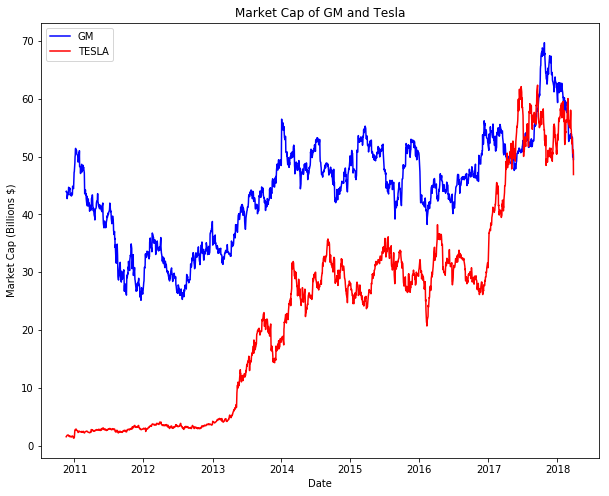

In [55]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'b-', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of GM and Tesla')
plt.legend();

Observamos uma ascensão meteórica para a Tesla e um pequeno aumento para a General Motors ao longo dos dados. Tesla ultrapassa a GM em valor durante 2017!


In [56]:
import numpy as np
# Find the first and last time Tesla was valued higher than GM
first_date = cars.loc[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.loc[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


Durante esse período, a Tesla vendeu cerca de 48.000 carros, enquanto a GM vendeu 1.500.000. GM foi avaliado menos que Tesla durante um período em que vendeu 30 vezes mais carros! Isso definitivamente mostra o poder de um executivo persuasivo e um produto de alta qualidade - se extremamente baixo em quantidade. Embora o valor de Tesla seja agora menor do que a GM, uma boa pergunta pode ser: podemos esperar que a Tesla supere novamente a GM? Quando isso acontecerá? Para isso, recorremos a modelos aditivos para previsão, ou seja, para prever o futuro.


### Modelando com fbprophet 

O pacote prophet do Facebook foi lançado em 2017 para Python e R, e os cientistas de dados de todo o mundo se alegraram. Profeta é projetado para analisar séries temporais com observações diárias que exibem padrões em diferentes escalas de tempo. Ele também possui recursos avançados para modelar os efeitos de feriados em uma série de tempo e implementar pontos de mudança customizados, mas vamos nos ater às funções básicas para colocar um modelo em funcionamento. O profeta, como o quandl, pode ser instalado com o pip na linha de comando. 

Primeiro importamos o profeta e renomeamos as colunas em nossos dados para o formato correto. A coluna Data deve ser chamada de "ds" e a coluna de valor que queremos prever "y". Em seguida, criamos modelos de profeta e os adequamos aos dados, da mesma forma que um modelo de aprendizado de máquina do Scikit-Learn:

In [57]:
# conda install -c conda-forge fbprophet 
import fbprophet

In [58]:
# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9
# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(gm)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Ao criar os modelos profeta, configurei o ponto de mudança antes de 0,15, acima do valor padrão de 0,05. Esse hiperparâmetro é usado para controlar a sensibilidade da tendência às mudanças, com um valor mais alto sendo mais sensível e um valor menor menos sensível. 

Esse valor é usado para combater um dos mais importantes trade-offs no aprendizado de máquina: bias vs. variância. Se nos ajustarmos muito de perto aos nossos dados de treinamento, chamados overfitting, temos muita variação e nosso modelo não será capaz de generalizar bem com novos dados. 

Por outro lado, se o nosso modelo não capturar as tendências em nossos dados de treinamento, ele está sofrendo mal e tem muito preconceito. Quando um modelo está sub-ajustado, o aumento do ponto de mudança antes permite mais flexibilidade para o modelo se ajustar aos dados e, se o modelo for overfitting, a redução dos limites anteriores aumenta a flexibilidade. O efeito da escala anterior do ponto de mudança pode ser ilustrado pelas previsões gráficas feitas com uma faixa de valores:

<img src='./img/1_jEFOLncknBJ8cPQSBQDktA.png'>


Quanto maior a escala anterior do ponto de mudança, mais flexível o modelo e mais próximo ele se encaixa nos dados de treinamento. Isso pode parecer exatamente o que queremos, mas o aprendizado dos dados de treinamento muito bem pode levar ao overfitting e à incapacidade de fazer previsões com precisão em novos dados. 

Portanto, precisamos encontrar o equilíbrio certo entre os dados de treinamento e a capacidade de generalizar para novos dados. Como os estoques variam do dia-a-dia, e queremos que nosso modelo capture isso, eu aumentei a flexibilidade depois de experimentar vários valores. Na chamada para criar um modelo de profeta, também podemos especificar pontos de mudança, que ocorrem quando uma série temporal passa de crescente para decrescente, ou de aumentar lentamente para aumentar rapidamente (eles estão localizados onde a mudança de taxa na série temporal é maior) . 

Pontos de mudança podem corresponder a eventos significativos, como lançamentos de produtos ou oscilações macroeconômicas no mercado. Se não especificarmos pontos de mudança, o profeta os calculará para nós. Para fazer previsões, precisamos criar o que é chamado de dataframe futuro. Nós especificamos o número de períodos futuros para prever (dois anos) e a frequência das previsões (diárias). Em seguida, fazemos previsões com o modelo de profeta que criamos e o futuro do dataframe:


In [60]:
# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

Nossos dataframes futuros contêm o limite de mercado estimado de Tesla e GM para os próximos dois anos. Podemos visualizar previsões com a função de plotagem do profeta.

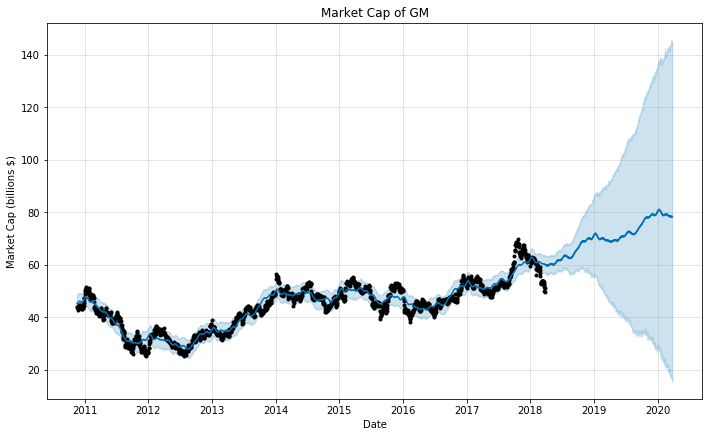

In [61]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM');

Os pontos pretos representam os valores reais (observe como eles param no início de 2018), a linha azul indica os valores previstos e a região sombreada azul clara é a incerteza (sempre uma parte crítica de qualquer previsão). 

A região da incerteza aumenta quanto mais longe no futuro a previsão é feita porque a incerteza inicial se propaga e cresce com o tempo. Isto é observado nas previsões meteorológicas que se tornam menos precisas quanto mais longe no tempo em que são feitas. Também podemos inspecionar pontos de mudança identificados pelo modelo. 

Novamente, os pontos de mudança representam quando a taxa de crescimento das séries temporais muda significativamente (passa de crescente a decrescente, por exemplo).


In [ ]:
gm_prophet.plot(gm_forecast,
                xlabel = 'Date',
                ylabel = 'Market Cap (billions $)')

In [62]:
tesla_prophet.changepoints[:10]

NameError: name 'tesla_prophet' is not defined

Para comparação, podemos analisar as Tendências de pesquisa do Google para Tesla nesse período para ver se as alterações estão alinhadas. Nós plotamos os pontos de mudança (linhas verticais) e as tendências de pesquisa no mesmo gráfico:

In [ ]:
# Load in the data 
tesla_search = pd.read_csv('data/tesla_search_terms.csv')
# Convert month to a datetime
tesla_search['Month'] = pd.to_datetime(tesla_search['Month'])
tesla_changepoints = [str(date) for date in tesla_prophet.changepoints]
# Plot the search frequency
plt.plot(tesla_search['Month'], tesla_search['Search'], label = 'Searches')
# Plot the changepoints
plt.vlines(tesla_changepoints, ymin = 0, ymax= 100, colors = 'r', linewidth=0.6, linestyles = 'dashed', label = 'Changepoints')
# Formatting of plot
plt.grid('off'); plt.ylabel('Relative Search Freq'); plt.legend()
plt.title('Tesla Search Terms and Changepoints');

Alguns dos pontos de mudança no valor de mercado de Tesla se alinham com as mudanças na frequência das pesquisas Tesla, mas não em todas elas. A partir disso, eu diria que a frequência de pesquisa relativa do Google não é um ótimo indicador de alterações de estoque. 


Ainda precisamos descobrir quando a capitalização de mercado da Tesla ultrapassará a da General Motors. Como temos as duas previsões para os próximos dois anos, podemos plotar as duas empresas no mesmo gráfico depois de mesclar os dataframes. Antes de mesclar, renomeamos as colunas para acompanhar os dados.


In [ ]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]
# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()
# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')
# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)

Primeiro vamos traçar apenas a estimativa. A estimativa (chamada "yhat" no pacote do profeta) suaviza parte do ruído nos dados para que pareça um pouco diferente dos gráficos brutos. O nível de suavidade dependerá da escala anterior do ponto de mudança - prévias mais altas significam um modelo mais flexível e mais altos e baixos.

<img src='./img/1_wtXXjTJK2J9MQFFkyGyhwA.png'>

Nosso modelo acredita que a breve ultrapassagem da GM pela Tesla em 2017 foi apenas ruído, e não é até o início de 2018 que a Tesla supera a GM definitivamente na previsão. A data exata é 27 de janeiro de 2018, então, se isso acontecer, eu ficarei feliz em receber o crédito por prever o futuro! 

Ao fazer o gráfico acima, deixamos de fora a parte mais importante de uma previsão: a incerteza! Podemos usar o matplotlib (veja o caderno) para mostrar as regiões de dúvida:

<img src='./img/1_0rt_W8NzoFG_WQ0I9mncyg.png'>


Esta é uma representação melhor da previsão. Isso mostra que o valor de ambas as empresas deve aumentar, mas a Tesla vai aumentar mais rapidamente do que a General Motors. Mais uma vez, a incerteza aumenta com o tempo como esperado para uma previsão e o limite inferior de Tesla está abaixo do limite superior da GM em 2020, significando que a GM poderia manter a liderança. Tendências e Padrões O último passo da análise de capitalização de mercado é analisar a tendência geral e os padrões. Profeta nos permite visualizar facilmente a tendência geral e os padrões de componentes:


In [ ]:
# Plot the trends and patterns
gm_prophet.plot_components(gm_forecast)

A tendência é bastante clara: as ações da GM estão subindo e indo continuar subindo. O padrão anual é interessante porque parece sugerir que a GM aumenta de valor no final do ano com um declínio longo e lento no verão. Podemos tentar determinar se existe uma correlação entre o valor de mercado anual e as vendas médias mensais da GM ao longo do período de tempo. Primeiro, juntei as vendas mensais de veículos do Google e calculei a média ao longo dos meses usando groupby. Essa é outra operação crítica da ciência de dados, porque muitas vezes queremos comparar estatísticas entre categorias, como usuários de uma faixa etária específica ou veículos de um fabricante. Nesse caso, queremos calcular as vendas médias em cada mês, então agrupamos os meses e, em seguida, calculamos a média das vendas.


In [ ]:
gm_sales_grouped = gm_sales.groupby('Month').mean()

Não parece que as vendas mensais estão correlacionadas com o valor de mercado. As vendas mensais são as segundas mais altas em agosto, o que é justo no ponto mais baixo para o valor de mercado! Olhando para a tendência semanal, não parece haver nenhum sinal significativo (não há preços de ações registrados nos finais de semana, então olhamos para a mudança durante a semana). Isso é de se esperar, como a teoria da caminhada aleatória em economia afirma lá. Não há um padrão previsível nos preços das ações em uma base diária. 

Como evidenciado por nossa análise, no longo prazo, as ações tendem a aumentar, mas na escala do dia-a-dia quase não há um padrão que possamos aproveitar, mesmo com os melhores modelos. Um simples olhar para o Dow Jones Industrial Average (um índice de mercado das 30 maiores empresas da bolsa de valores) ilustra bem esse ponto:

<img src='./img/1_5OHpAvp_w5g7jccqJ8OYaA (1).png'>


Claramente, a mensagem é voltar a 1900 e investir seu dinheiro! Ou, na realidade, quando o mercado cai, não se retire porque ele voltará de acordo com o histórico. Na escala global, as flutuações do dia-a-dia são muito pequenas para serem vistas e se estamos pensando como cientistas de dados, percebemos que jogar ações cotidianas é tolo comparado a investir em todo o mercado e manter por longos períodos de tempo . 

O Profeta também pode ser aplicado a medidas de dados em larga escala, como o Produto Interno Bruto, uma medida do tamanho total da economia de um país. Fiz a seguinte previsão criando modelos proféticos baseados no PIB histórico dos EUA e da China.

<img src='./img/1_1I9G9ek3oXmuS2Fa9KVf9g.png' >

A data exata em que a China ultrapassará os EUA no PIB é 2036! Esse modelo é limitado por causa da baixa frequência das observações (o PIB é medido uma vez por trimestre, mas o profeta funciona melhor com dados diários), mas fornece uma previsão básica sem o conhecimento macroeconômico necessário. 


Há muitas maneiras de modelar séries temporais, desde a regressão linear simples até redes neurais recorrentes com células LSTM. Modelos aditivos são úteis porque são rápidos de desenvolver, rápidos de treinar, fornecem padrões interpretáveis e fazem previsões com incertezas. As capacidades do Profeta são impressionantes e nós apenas arranhamos a superfície aqui. Encorajo-o a usar este artigo e o caderno para explorar alguns dos dados oferecidos por Quandl ou sua própria série temporal. 

Fique atento para futuros trabalhos sobre análise de séries temporais, e para uma aplicação do profeta em minha vida diária, veja meu post sobre como usar essas técnicas para modelar e prever a mudança de peso. Como primeiro passo para explorar as séries temporais, os modelos aditivos em Python são o caminho a percorrer!


### Parte 3

<img src='./img/0_4XXSSYy4nYDDgNex.jpg' >

In [75]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True,
                 plot_anomalies=True)

NameError: name 'X_train_scaled' is not defined